# 3.02 Sync voices

* The voices are now synchronized
* Each voice has an own rolling mean window and scale factor
* Functions which are no longer part of this development step are __exported to the music_generation.py file.__ The file is found at the __end__ of the page.

In [18]:
from pyknon.genmidi import Midi
from pyknon.music import Rest, Note, NoteSeq
from music_generation import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from datetime import date

## Transform Meteo data

In [19]:
def scale(a):    return (a-a.min())/(a.max()-a.min())

def read_meteo_data(fName):
    colNames = ['Stao','time', 'Flash', 'p_QNH', 'T_2m', 'Precip', 'H_rel', 'V_wind']  
    df = pd.read_csv(fName,sep=';', skiprows=3, names=colNames, na_values='-')
    print(df.head())
    return df

fPath = '/mnt/daten/04_Schule/42_Kanti/Matrua/Music_generation/Organisation/MeteoSchweiz/Daten/'
fName = 'order_74678_data.txt'
dM = read_meteo_data(fPath+fName)

#---- Parameter bestimmen -----------
NT, MP = dM.shape
print('-----------------')
print('NT, MP', NT, MP)



  Stao          time  Flash  p_QNH  T_2m  Precip  H_rel  V_wind
0  KLO  201908280000      0  968.5  19.6     0.0   90.1     0.6
1  KLO  201908280010      0  968.5  19.3     0.0   93.0     0.6
2  KLO  201908280020      0  968.6  19.4     0.0   90.6     0.7
3  KLO  201908280030      0  968.7  19.6     0.0   90.3     0.7
4  KLO  201908280040      0  968.7  18.7     0.0   95.6     0.5
-----------------
NT, MP 2016 8


__met_transform__


* the __rolling mean__ is to remove noise on the data. 
* the __factors__ are used to scale the melody, such that it plays in a certain range
* __start__ defines the staring point of the melodies by removing the begin of the data

In [124]:
def met_transform(dM,factors,means,start):
    col_nr = dM.shape[1]-2
    start = int(start*6)
    cut_border = np.trunc((np.amax(means))/2).astype(int)   # calculate nr of nan at the border because of the rolling mean
    cut_begin = np.amax([cut_border,start])
    trans = np.zeros((col_nr, (dM.shape[0]  -cut_border -cut_begin))) 
    if col_nr != len(factors) or col_nr != len(means): print('dM,factor,mean not same length')
    
    for nr,factor, mean in zip(range(col_nr),factors,means):                                          
        Yw  = np.array(dM[dM.columns[nr +2]].rolling(window=mean,center=True).mean()) # nr+2 the first two colums are location and date.
        Yw = Yw * factor
        trans[nr] = Yw[cut_begin: -cut_border]  # remove nan at begining and end. because of rolling mean
        
    return trans

__Chords and scales__

In [125]:
major = np.array([ 0, 2, 4, 5, 7, 9, 11])
minor = np.array([ 0, 2, 3, 5, 7, 8, 10])  
C7 = np.array([ 0, 4, 7, 10]) 
CM7 = np.array([ 0, 4, 7, 11])
Cm7 = np.array([ 0, 3, 7, 10])
Cm  = np.array([ 0, 3, 7])
C   = np.array([ 0, 4, 7])
bass= np.array([ 0])

## Tune U 

This tune uses the wind and temperature data, starting after 80 hours --> 30.8.2019

In [138]:
def meteo_melody(meteo, pattern, start_note, a_range, notenr, rythem,mpb):
    melody = np.zeros(notenr, dtype=int)
    cum_rythem = np.cumsum(rythem) *4             
    cum_rythem = np.concatenate(([0],cum_rythem)) # add 0 at beginig 
    
    scale_change = pattern[:,0]
    scale_nr =0
    scale = pattern[scale_nr,1]
    melody[0] = scale[i_last_note(start_note,scale)]
    
    for npn in range(1, notenr):  #npn: note per note (index)      
        
        scale_nr = np.ravel(np.argwhere(scale_change <= cum_rythem[npn-1])) [-1]     
        scale = pattern[scale_nr,1]
        
        # find interval
        met_resolution = 10
        inter = np.asarray([cum_rythem[npn-1], cum_rythem[npn]])  # get beat_nr's 
        inter = np.round((inter*mpb)/met_resolution).astype(int)  # calulate index of the data array
        intvl = meteo[inter[1]] - meteo[inter[0]]                 # take the diffrence of the data
        intvl = np.round(intvl).astype(int)                       # round to an int
        
        inote_befor = i_last_note(melody[npn-1],scale)    # get i in the scale of the last note
        inote = inote_befor + intvl                       # calculate i in scale of note    
        melody[npn] = scale[inote]                        # set in to melody
         
    #print(melody)
    plt.plot(cum_rythem[1:],melody) ; plt.xlabel= ('beat nr.'); plt.ylabel=('midi note nr')
    return melody

In [139]:
def tune_U():
    tune_name = 'tune_U'  
    #np.random.seed(23)
    bar, bpb = 12, 4  # bar: Takt , bpb: beat per bar
    melody_len = bar * bpb
    mpb = 70   #minutes per beat.
    start = 79.5      # start in hours 
    
    trans = met_transform(dM,[1,2.5,0.8,1,0.3,4.5],[6,6,6,6,6,2],start)
    #plt.plot(trans[5,:300])
    #np.set_printoptions(threshold=np.inf)
    #print(trans[1,::20])
    
    
    scales = [[1,CM7],[1,Cm7+9],[1,Cm7+2],[1,C7+7]] #rythem Change
    #scales = [[4,C7],[2,C7+5],[2,C7],[1,C7+7],[1,C7+5],[2,C7]] # Blues  
    scales = [[8,minor]]
    pattern = pattern_gen(scales, melody_len)
    
    range_1 = liniar_range(44,51,70,76)
    rythem1, notenr_1 = ran_duration([1/16,1/8, 1/4,1/2], [2,4,1,0], melody_len)
    melody1 = meteo_melody(trans[5],pattern, 72, range_1, notenr_1, rythem1,mpb)
    volumes1 = ran_volume([0,120], [1,8], notenr_1 )
    notes1 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody1,rythem1,volumes1)] )
    
    range_2 = liniar_range(44,51,70,76)
    rythem2, notenr_2 = ran_duration([1/16,1/8, 1/4,1/2], [0,2,3,2], melody_len)
    melody2 = meteo_melody(trans[4],pattern, 65, range_2, notenr_2, rythem2,mpb)
    volumes2 = ran_volume([0,120], [1,8], notenr_2 )
    notes2 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody2,rythem2,volumes2)] )

    
    #plot_range([range_1],['range_1'],tune_name)
    instruments = [10,49]
    notes = [notes1,notes2]
    return notes, instruments,tune_name

__Instruments:__
Available are at lest the 128 General-Midi (GM) Instruments. Depending on the sound-fonts there is a bigger choice. A list of the GM instruments can be found here. https://jazz-soft.net/demo/GeneralMidi.html


## Generate Midi and Audio file

In [140]:
def gen_midi():
#     squezze into a MIDI framework
    notes, instruments, tune_name = tune_U() #  <--- select a tune  <<--     <<<<<<<<<--- select a tune -----
    nTracks = len(notes)
    
    m = Midi(number_tracks=nTracks, tempo=120, instrument=instruments)
    for iTrack in range(nTracks):
        m.seq_notes(notes[iTrack], track=iTrack)

    #--- write the MIDI file -----
    midi_file_name = tune_name +'.mid'   # set the name of the file
    m.write(midi_file_name)
    return midi_file_name

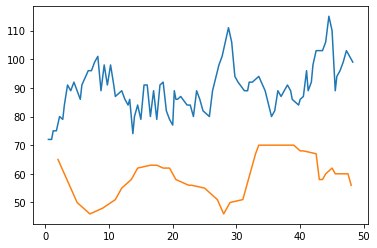

In [141]:
######---  Main  ---######
midi_file_name = gen_midi()

midi_play(midi_file_name)
midi_audio(midi_file_name)
midi_png(midi_file_name)

## External __Music_Generation__ library
This library changes from version to version. New or changed code is first explained above. This is a copy of music_generation.py 